In [79]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load your data
df = pd.read_csv('netflix.csv')

df.isnull().sum()


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [80]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [81]:

# Fill missing values with 'Unknown' for categorical columns
df[['director', 'cast', 'country']] = df[['director', 'cast', 'country']].fillna('Unknown')



# Drop other null records
df=df.dropna()

df.isnull().sum()



show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [82]:

# Convert date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')


# Extract year and month from date_added
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_added'] = df['date_added'].dt.day

# Fill missing values for year_added and month_added
df['year_added'].fillna(df['year_added'].mode()[0], inplace=True)
df['month_added'].fillna(df['month_added'].mode()[0], inplace=True)
df['day_added'].fillna(df['day_added'].mode()[0], inplace=True)

# Drop the original date_added column
df.drop('date_added', axis=1, inplace=True)


In [120]:
# Convert the multi-valued features to lists
multi_valued_features = ['cast', 'country', 'listed_in', 'director']
for feature in multi_valued_features:
    df[feature] = df[feature].apply(lambda x: [i.strip() for i in str(x).split(",")])



In [83]:
# First, split the 'duration' column into numerical part and unit part
df[['duration_number', 'duration_unit']] = df['duration'].str.split(' ', expand=True)
df['duration_number'] = df['duration_number'].astype(int)

# Now separate movies and TV shows into two different DataFrames
df_movies = df[df['type'] == 'Movie']
df_tvshows = df[df['type'] == 'TV Show']

# For movies, we can calculate the IQR and remove outliers
Q1 = df_movies['duration_number'].quantile(0.25)
Q3 = df_movies['duration_number'].quantile(0.75)
IQR = Q3 - Q1
df_movies = df_movies[~((df_movies['duration_number'] < (Q1 - 1.5 * IQR)) | (df_movies['duration_number'] > (Q3 + 1.5 * IQR)))]

# For TV Shows, assuming a TV Show having 1 or 2 seasons is common and thus not an outlier, we do not need to remove these records
# However, if you do want to treat them as outliers, you can use the same code as above to calculate IQR and remove outliers

# Finally, you can combine the data back if needed
df = pd.concat([df_movies, df_tvshows])


In [84]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    text = text.lower()  # Lowercase
    text = nltk.word_tokenize(text)  # Tokenize
    text = [word for word in text if word not in stop_words]  # Remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatize
    return ' '.join(text)

# Apply text processing to the 'description' column
df['description'] = df['description'].apply(process_text)
df['description'].head()

[nltk_data] Downloading package stopwords to /home/amir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0     father nears end life , filmmaker kirsten john...
6     equestria 's divided . bright-eyed hero belief...
7     photo shoot ghana , american model slip back t...
9     woman adjusting life loss contends feisty bird...
12    family murdered terrorist bombing , young woma...
Name: description, dtype: object

In [85]:

df.to_csv('Netflix_Shows_Preprocessed.csv', index=False)


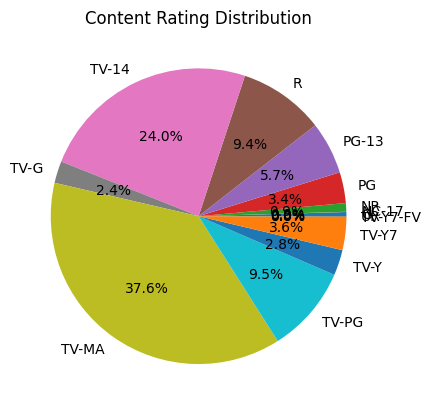

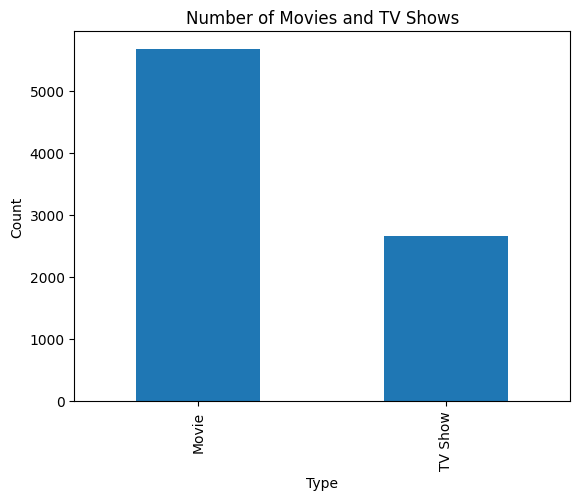

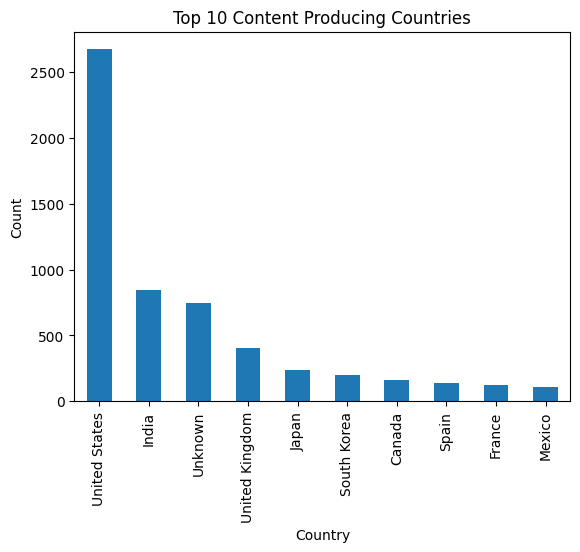

In [86]:
import matplotlib.pyplot as plt





grp = df.groupby(['rating']).size().reset_index(name='counts')

plt.pie(grp['counts'], labels=grp['rating'], autopct='%1.1f%%')
plt.title('Content Rating Distribution')
plt.show()

# Display the number of movies and TV shows
df['type'].value_counts().plot(kind='bar')
plt.title('Number of Movies and TV Shows')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# Display the top 10 countries producing the most content
df['country'].value_counts()[:10].plot(kind='bar')
plt.title('Top 10 Content Producing Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

# Other analysis could include rating distributions, most popular actors, etc.


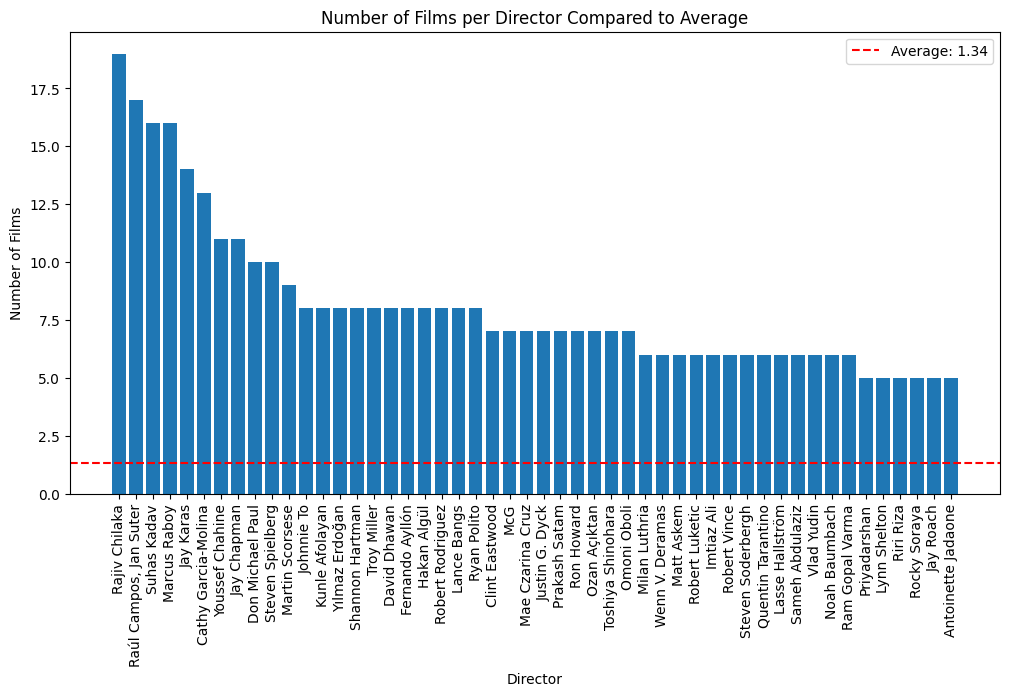

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'director' column contains lists of directors for each movie
# Convert these lists into separate rows
df = df.loc[df['director'] != 'Unknown']
df_exploded = df.explode('director')

director_counts = df_exploded['director'].value_counts()

# Compute average
average_movies = director_counts.mean()

# Generate the plot
plt.figure(figsize=(12,6))
plt.bar(director_counts.index[:50], director_counts.values[:50])  # Display top 50 directors
plt.axhline(y=average_movies, color='r', linestyle='--', label=f'Average: {average_movies:.2f}')
plt.xlabel('Director')
plt.ylabel('Number of Films')
plt.title('Number of Films per Director Compared to Average')
plt.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


In [88]:

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Convert string lists to actual lists
df['cast'] = df['cast'].str.split(', ')
df['listed_in'] = df['listed_in'].str.split(', ')

# Concatenate director, cast and genres into one list
df['items'] = df['director'].apply(lambda x: [x]) + df['cast'] + df['listed_in']

# Convert DataFrame into transaction-like format
te = TransactionEncoder()
te_array = te.fit(df['items']).transform(df['items'])
df_transactions = pd.DataFrame(te_array, columns=te.columns_)

# Compute frequent items using the Apriori algorithm
frequent_items = apriori(df_transactions, min_support=0.01, use_colnames=True)

# Compute all association rules for frequent_items
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.1)

# Strong Rules
strong_rules = rules[(rules['lift'] >= 1) & (rules['confidence'] >= 0.7) & (rules['antecedent support'] >= 0.1 ) ]
print(strong_rules)


             antecedents consequents  antecedent support  consequent support  \
28  (Independent Movies)    (Dramas)            0.127358             0.38588   

     support  confidence      lift  leverage  conviction  zhangs_metric  
28  0.098979    0.777174  2.014031  0.049834    2.756051       0.576964  


In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd

# Assuming the data is in a csv file named 'netflix_data.csv'
df = pd.read_csv('Netflix_Shows_Preprocessed.csv')

# Preparing data
X = df['description'] + ' ' + df['director'] + ' ' + df['cast'] + ' ' + df['country']
y = df['listed_in']

# Creating a pipeline that first transforms the data using TF-IDF and then applies Random Forest classifier
model = make_pipeline(TfidfVectorizer(stop_words='english'), RandomForestClassifier(random_state=42))

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],  # Adjust the n-gram range as per your dataset
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X, y)

# Best hyperparameters and corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Evaluating the model with cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='f1_weighted')

print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())

# Alternatively, you can use train_test_split for evaluating on a holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluating the model on the holdout set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)


/home/amir/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
